Con questo Jupyter Notebook voglio mostrare come ho elaborato i dati CAMS relativi al PM10 di cui ho parlato in [questo articolo](https://massimilianomoraca.me/blog/gis/pm10-nord-italia/). I dati grezzi sono in formato NetCDF e di come gestire questo particolare formato dati ne ho parlato in un [altro articolo](https://massimilianomoraca.me/blog/pygis-blog/gestione-di-un-file-netcdf/) che, nemmeno a farlo apposta, è incentrato sui dati CAMS.

# Prima di iniziare

## Librerie

Le librerie Python usate per raggiungere lo scopo sono state diverse e le vedrete di seguito. Una però deve essere menzionata tra tutte [Dask](https://www.dask.org/); senza l'uso di questa librerie non mi sarebbe stato possibile velocizzare i processamenti che, nonostante tutto, sono durati ore.

In [16]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from xrspatial.zonal import stats
from geocube.api.core import make_geocube

from pandas import DataFrame
from xarray import Dataset, DataArray
from geopandas import GeoDataFrame
from typing import Union

## Fonti dati

I dati del PM10 dal 2013 allo scorso marzo sono il perno di questa analisi a cui ho associato i dati vettoriali dell'ISTAT delle province target(quelle che ricadono nelle regioni con codice da 1 a 11) e sulla popolazione per cella censuaria. Dopo aver scaricato i dati CAMS li ho preprocessati in modo da avere un file `.nc` per anno.

In [7]:
nc_data_path = Path("/home/max/Desktop/pianura_padana/processed/netcdf")

nc_files = list(nc_data_path.glob("*.nc"))

nc_files

[PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2021-forecasts.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2017-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2020-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2014-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2013-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2016-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2023-forecasts.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2019-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2015-reanalyses.nc'),
 PosixPath('/home/max/Desktop/

In [26]:
target_zones_boundaries = Path("/home/max/Desktop/DEV/DrakoNotebook/open_dataset/Limiti01012023_g/ProvCM01012023_g/ProvCM01012023_g_WGS84.shp")
#target = [1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 15, 16, 17, 18, 19, 20, 96, 97, 98, 103, 108]

target_zones = gpd.read_file(target_zones_boundaries)
target_zones = target_zones[target_zones['COD_REG'].isin(list(range(1, 12)))]
target_zones = target_zones.to_crs(4326).sort_values('DEN_UTS')

target_zones

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,Shape_Area,geometry
5,1,1,6,0,6,Alessandria,-,Alessandria,AL,Provincia,3.560310e+09,"POLYGON ((8.40549 45.20148, 8.41749 45.19846, ..."
41,3,11,42,0,42,Ancona,-,Ancona,AN,Provincia,1.961932e+09,"POLYGON ((13.21155 43.72501, 13.21979 43.71770..."
6,1,2,7,0,7,Aosta,-,Aosta,AO,Provincia,3.258838e+09,"POLYGON ((7.58857 45.97075, 7.58981 45.97073, ..."
50,3,9,51,0,51,Arezzo,-,Arezzo,AR,Provincia,3.233326e+09,"MULTIPOLYGON (((12.21800 43.60394, 12.21816 43..."
43,3,11,44,0,44,Ascoli Piceno,-,Ascoli Piceno,AP,Provincia,1.229268e+09,"POLYGON ((13.78663 43.07104, 13.79679 43.06211..."
...,...,...,...,...,...,...,...,...,...,...,...,...
26,2,5,27,227,227,-,Venezia,Venezia,VE,Citta metropolitana,2.473732e+09,"POLYGON ((12.79994 45.82573, 12.80158 45.82316..."
102,1,1,103,0,103,Verbano-Cusio-Ossola,-,Verbano-Cusio-Ossola,VB,Provincia,2.262145e+09,"POLYGON ((8.44976 46.46176, 8.46176 46.45081, ..."
1,1,1,2,0,2,Vercelli,-,Vercelli,VC,Provincia,2.082097e+09,"POLYGON ((8.20447 45.93567, 8.21365 45.92490, ..."
22,2,5,23,0,23,Verona,-,Verona,VR,Provincia,3.096255e+09,"POLYGON ((10.88379 45.77281, 10.88301 45.77202..."


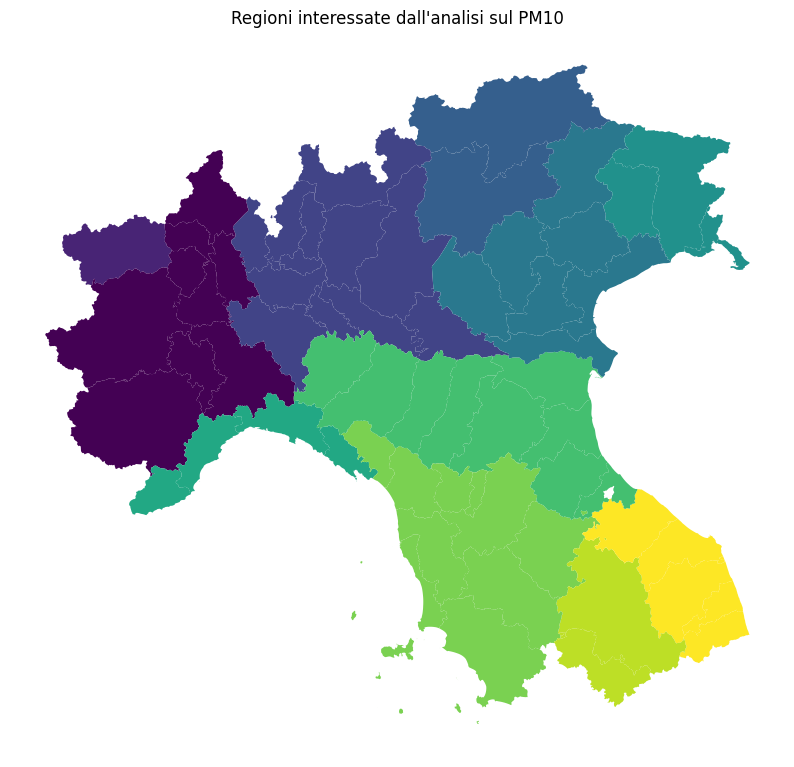

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

target_zones.plot(
    ax=ax,
    column='COD_REG',
)
plt.title("Regioni interessate dall'analisi sul PM10")
plt.axis('off')
plt.show()

## Funzioni custom

Un'altra attività importante è stata quella legata allo sviluppo di funzioni custom che mi hanno consentito di ottimizzare il lavoro. Alcune di esse sono entrate a far parte del mio personale package Python che ho sviluppato negli anni per l'analisi dei dati satellitari e le ho quindi un po' più "ingegnerizzate":

In [ ]:
# def read_scientific_dataset(
#         input_data: Union[str, Path],
#         engine: str = "netcdf4",
#         mask_layer: GeoDataFrame = None,
#         parallel: bool = False
# ) -> Dataset:
#     """Read netCDF, Zarr, h5netcdf, scipy file format and return a Dataset.
# 
#     Args:
#         input_data: Union[str, Path]
#         engine: str
#         mask_layer: GeoDataFrame
#         parallel: bool
# 
#     Returns:
#         Dataset
#     """
#     if parallel:
#         data = xr.open_mfdataset(
#             paths=input_data,
#             engine=engine,
#             decode_coords="all",
#             parallel=True
#         )
#     else:
#         data = xr.open_dataset(
#             filename_or_obj=input_data,
#             engine=engine,
#             decode_coords="all"
#         )
#     data.rio.write_crs(4326, inplace=True)
# 
#     if mask_layer is not None:
# 
#         # Make selection mask
#         bounds = mask_layer.bounds.squeeze()
#         lon_min = round(bounds["minx"], 0) - 1
#         lon_max = round(bounds["maxx"], 0)
#         lat_min = round(bounds["miny"], 0) - 1
#         lat_max = round(bounds["maxy"], 0)
# 
#         # Apply mask
#         latitude_slice = slice(lat_min, lat_max)
#         longitude_slice = slice(lon_min, lon_max)
# 
#         data = data.sel(lat=latitude_slice, lon=longitude_slice)
# 
#     return data
# 
# 
# def zonal_statistics(
#         vector_data: GeoDataFrame,
#         ref_col: str,
#         raster_data: DataArray,
#         output_file_path: Path = None,
#         output_format: str = None,
#         output_file_name: str = 'zonal_statistics'
# ) -> Union[DataFrame, Path]:
#     """Calculate zonal statistics.
# 
#     Args:
#         vector_data: GeoDataFrame.
#         ref_col: str. Column with data to rasterize.
#         raster_data: DataArray.
#         output_file_path: str.
#         output_format: str. Accepted csv, xlsx or json
#         output_file_name: str.
# 
#     Returns:
#         Union[GeoDataFrame, Path]
# 
#     Raises:
#         Not supported file format. Must be csv, xlsx or json.
#     """
#     # Check if vector and raster has same EPSG
#     if str(raster_data.rio.crs).lower() != str(vector_data.crs):
#         raster_data = raster_data.rio.reproject(vector_data.crs)
# 
#     # Drop raster band. Raster and rasterized vector must have the same shape.
#     raster_data = raster_data.squeeze()
# 
#     # Drop nodata
#     raster_data = raster_data.where(raster_data != raster_data.rio.nodata)
# 
#     # Rasterize vector
#     rasterized_vector = make_geocube(
#         vector_data=vector_data,
#         measurements=[ref_col],
#         like=raster_data,
#     )
#     vector_dataarray = rasterized_vector[ref_col]
# 
#     # Compute Zonal Statistics
#     compute_zonal_statistics = stats(
#         zones=vector_dataarray,
#         values=raster_data,
#         stats_funcs=["mean", "max", "min", "sum", "std", "count", "var"]
#     )
# 
#     # Drop nodata values
#     compute_zonal_statistics = compute_zonal_statistics.astype(float).dropna()
#     compute_zonal_statistics.rename(columns={"zone": ref_col}, inplace=True)
# 
#     if output_file_path is None:
#         return compute_zonal_statistics
#     else:
# 
#         if output_file_name is not None:
#             output_file = output_file_path.joinpath(f"zonalstatistics.{output_format}")
#         else:
#             output_file = output_file_path.joinpath(f"{output_file_name}.{output_format}")
# 
#         if output_format == 'json':
#             # Save as JSON
#             compute_zonal_statistics.to_json(output_file)
#         elif output_format == 'csv':
#             # Save as CSV
#             compute_zonal_statistics.to_csv(output_file)
#         elif output_format == 'xlsx':
#             # Save as CSV
#             compute_zonal_statistics.to_excel(output_file, sheet_name='zonal_statistics')
#         else:
#             raise Exception('Not supported file format. Must be csv, xlsx or json.')
# 
#         return output_file

## Contenuti
- [Aggregazione dei dati](#Aggregazione-dei-dati)
- 
- [Conclusione](#Conclusione)

# Aggregazione dei dati

Lo scopo di questa attività è stato quello di aggregare i dati su base provinciale e di generare un `.csv` per Provincia.